# AI Tools for Actuaries
## Chapter 8: Word2vec skip-gram with negative sampling
**Author:** Mario Wuthrich  
**Version:** September, 2025  

In [1]:
# Import required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import os
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
    
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

print("Libraries imported successfully")


Libraries imported successfully


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MarioW\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Loading

Loading data from Parquet format file.


In [2]:
# Load data from Parquet format
data_text = pd.read_parquet("../../Data/data_text.parquet")
print(f"Data shape: {data_text.shape}")
print(f"Columns: {list(data_text.columns)}")
print("\nFirst 10 rows:")
print(data_text.head(10))


Data shape: (5424, 2)
Columns: ['Hazard', 'Description']

First 10 rows:
      Hazard                                        Description
0  Lightning  lightning damage                              ...
1  Lightning  lightning damage at Comm. Center              ...
2  Vandalism  surveillance equipment stolen                 ...
3  Vandalism  vandalism damage at recycle center            ...
4       Wind  wind blew stack off and damaged roof          ...
5    Vehicle  forklift hit building damaging wall and door f...
6  Lightning  lightning damage at water tower               ...
7  Lightning  lightning damge to radio tower                ...
8  Lightning  Lightning Surge                               ...
9  Lightning  lightning damage at water tower               ...


## Data Cleaning

This section performs comprehensive text cleaning including:
- Remove stopwords
- Convert to lowercase
- Remove numbers and punctuation
- Remove specific damage-related words
- Lemmatization
- Remove single characters


In [3]:
# Initialize cleaning tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


data_text['clean'] = data_text['Description'].str.lower()

# Remove stopwords
data_text['clean'] = data_text['clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Remove numbers
data_text['clean'] = data_text['clean'].apply(lambda x: re.sub(r'\d+', '', x))


# Remove punctuation but preserve intra-word dashes
data_text['clean'] = data_text['clean'].apply(lambda x: re.sub(r'(\w)-(\w)', r'\1TEMPDASH\2', x))
data_text['clean'] = data_text['clean'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
data_text['clean'] = data_text['clean'].apply(lambda x: x.replace('TEMPDASH', '-'))


# Remove specific damage-related words
damage_words = ["damage", "damaged", "damge", "dmage", "dmgd", "damged",
                   "dmaged", "damgae", "damage", "damaging", 
                   "damagd", "damg", "damags", "damagess"]
data_text['clean'] = data_text['clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in damage_words]))
    
# Lemmatization
data_text['clean'] = data_text['clean'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Remove single isolated letters
data_text['clean'] = data_text['clean'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))


print(data_text.head(5))
    
  

      Hazard                                        Description  \
0  Lightning  lightning damage                              ...   
1  Lightning  lightning damage at Comm. Center              ...   
2  Vandalism  surveillance equipment stolen                 ...   
3  Vandalism  vandalism damage at recycle center            ...   
4       Wind  wind blew stack off and damaged roof          ...   

                           clean  
0                      lightning  
1          lightning comm center  
2  surveillance equipment stolen  
3       vandalism recycle center  
4           wind blew stack roof  


## Tokenization and Vocabulary Building

This section creates a tokenizer and builds vocabulary, filtering words that appear at least 20 times.


In [4]:
# Create tokenizer and build vocabulary
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# First tokenizer to count all words
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(data_text['clean'])

# Get word counts
word_counts = tokenizer1.word_counts
print(f"Total unique words: {len(word_counts)}")

# Minimum occurrence threshold
min_occurrence = 20
words_to_keep = {word: count for word, count in word_counts.items() if count >= min_occurrence}
print(f"Words with at least {min_occurrence} occurrences: {len(words_to_keep)}")

# Create second tokenizer with limited vocabulary
num_words = len(words_to_keep) + 1  # +1 for padding token
tokenizer2 = Tokenizer(num_words=num_words)
tokenizer2.fit_on_texts(data_text['clean'])

print(f"Final vocabulary size: {len(tokenizer2.word_index)}")
print(f"Max words parameter: {num_words}")

# Convert texts to sequences
sequences = tokenizer2.texts_to_sequences(data_text['clean'])

# Check sequence lengths
seq_lengths = [len(seq) for seq in sequences]
max_length = max(seq_lengths) if seq_lengths else 0
print(f"Maximum sequence length: {max_length}")

# Count texts with more than one word vs single word
multi_word_texts = sum(1 for length in seq_lengths if length > 1)
single_word_texts = sum(1 for length in seq_lengths if length <= 1)
print(f"Texts with more than one word: {multi_word_texts}")
print(f"Texts with one word or less: {single_word_texts}")

# Display first few words in vocabulary
print("\nFirst 20 words in vocabulary:")
for i in range(1, min(21, len(tokenizer2.index_word) + 1)):
    if i in tokenizer2.index_word:
        print(f"{i}: {tokenizer2.index_word[i]}")


Total unique words: 1901
Words with at least 20 occurrences: 126
Final vocabulary size: 1901
Max words parameter: 127
Maximum sequence length: 7
Texts with more than one word: 3791
Texts with one word or less: 1633

First 20 words in vocabulary:
1: vandalism
2: lightning
3: water
4: glass
5: park
6: fire
7: light
8: wind
9: door
10: pole
11: vehicle
12: power
13: theft
14: building
15: surge
16: signal
17: school
18: hit
19: traffic
20: graffiti


## Building Skip-grams with Negative Sampling

This section generates positive (true) center-context word pairs and negative (fake) pairs for training the Word2Vec model.


In [5]:
# Generate skip-grams with negative sampling
def generate_skipgrams(sequences, vocabulary_size, window_size=2):
    """
    Generate skip-gram pairs from sequences
    """
    skipgrams_data = []
    
    for seq in sequences:
        if len(seq) > 1:  # Only consider sequences with more than one word
            for i, center_word in enumerate(seq):
                # Define context window
                start = max(0, i - window_size)
                end = min(len(seq), i + window_size + 1)
                
                for j in range(start, end):
                    if i != j:  # Don't pair word with itself
                        context_word = seq[j]
                        if center_word < vocabulary_size and context_word < vocabulary_size:
                            skipgrams_data.append([center_word, context_word, 1])  # 1 for real pair
    
    return skipgrams_data

# Generate real skip-gram pairs
print("Generating real skip-gram pairs...")
window_size = 2
vocabulary_size = num_words

positive_skipgrams = generate_skipgrams(sequences, vocabulary_size, window_size)
print(f"Generated {len(positive_skipgrams)} real skip-gram pairs")

# Convert to DataFrame for easier manipulation
skipgram_df = pd.DataFrame(positive_skipgrams, columns=['w1', 'w2', 'label'])

# Generate fake skip-gram pairs
print("Generating fake skip-gram pairs...")
negative_skipgrams = skipgram_df.copy()
negative_skipgrams['label'] = 0  # 0 for fake pairs

# Shuffle the context words (w2) to create fake pairs
np.random.seed(100)  
shuffled_indices = np.random.permutation(len(negative_skipgrams))
negative_skipgrams['w2'] = negative_skipgrams.iloc[shuffled_indices]['w2'].values

# Combine positive and negative samples
all_skipgrams = pd.concat([skipgram_df, negative_skipgrams], ignore_index=True)

# Shuffle the combined dataset
all_skipgrams = all_skipgrams.sample(frac=1, random_state=100).reset_index(drop=True)

print(f"Total skip-gram pairs: {len(all_skipgrams)}")
print(f"Positive pairs: {sum(all_skipgrams['label'])}")
print(f"Negative pairs: {len(all_skipgrams) - sum(all_skipgrams['label'])}")

print("\nFirst 10 skip-gram pairs:")
print(all_skipgrams.head(10))


Generating real skip-gram pairs...
Generated 15678 real skip-gram pairs
Generating fake skip-gram pairs...
Total skip-gram pairs: 31356
Positive pairs: 15678
Negative pairs: 15678

First 10 skip-gram pairs:
    w1   w2  label
0   34    5      1
1    7   30      0
2   12    4      0
3    5    4      0
4   13    2      0
5   21    2      1
6   92    4      0
7   59  113      1
8  102    9      0
9   12   11      0


## Word2Vec Neural Network Architecture

This section defines the neural network for Word2Vec using skip-gram with negative sampling. The model uses two embedding layers (center and context) and predicts whether word pairs are real or fake.


In [6]:
# Define Word2Vec network architecture
def create_word2vec_model(vocab_size, embedding_dim, seed=100):
    """
    Create Word2Vec model with skip-gram architecture
    """
    # Clear any existing session
    tf.keras.backend.clear_session()
    
    # Set seeds for reproducibility
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
    # Input layers
    center_input = layers.Input(shape=(1,), dtype='int32', name='center')
    context_input = layers.Input(shape=(1,), dtype='int32', name='context')
    
    # Embedding layers
    center_embedding = layers.Embedding(
        input_dim=vocab_size, 
        output_dim=embedding_dim, 
        input_length=1,
        name='centerEmb'
    )(center_input)
    center_embedding = layers.Flatten()(center_embedding)
    
    context_embedding = layers.Embedding(
        input_dim=vocab_size, 
        output_dim=embedding_dim, 
        input_length=1,
        name='contextEmb'
    )(context_input)
    context_embedding = layers.Flatten()(context_embedding)
    
    # Dot product of center and context embeddings
    dot_product = layers.Dot(axes=1)([center_embedding, context_embedding])
    
    # Output layer with sigmoid activation
    output = layers.Dense(1, activation='sigmoid')(dot_product)
    
    # Create and return model
    model = keras.Model(inputs=[center_input, context_input], outputs=output)
    
    return model



In [8]:
# Define the Word2Vec model

# Model parameters
embedding_dim = 2  # 2D embedding
vocab_size = num_words

# Create the model
print("Creating Word2Vec model...")
model = create_word2vec_model(vocab_size, embedding_dim, seed=123456)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='nadam',
    metrics=['accuracy']
)

# Display model architecture
print("\nModel architecture:")
model.summary()

# Prepare training data
center_data = all_skipgrams['w1'].values - 1  # Convert to 0-based indexing
context_data = all_skipgrams['w2'].values - 1  # Convert to 0-based indexing
labels = all_skipgrams['label'].values

print(f"\nTraining data shapes:")
print(f"Center data: {center_data.shape}")
print(f"Context data: {context_data.shape}")
print(f"Labels: {labels.shape}")


Creating Word2Vec model...

Model architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ center (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ centerEmb           │ (None, 1, 2)      │        254 │ center[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contextEmb          │ (None, 1, 2)      │        254 │ context[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ centerEmb[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2)         │          0 │ contextEmb[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ dot[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 510 (1.99 KB)

 Trainable params: 510 (1.99 KB)

 Non-trainable params: 0 (0.00 B)


Training data shapes:
Center data: (31356,)
Context data: (31356,)
Labels: (31356,)


## Model Training

Train the Word2Vec model with the skip-gram pairs. This section includes training monitoring and performance visualization.


Starting model training...
Epochs: 1000
Batch size: 5000
Validation split: 0.2

Training completed in 83.19 seconds


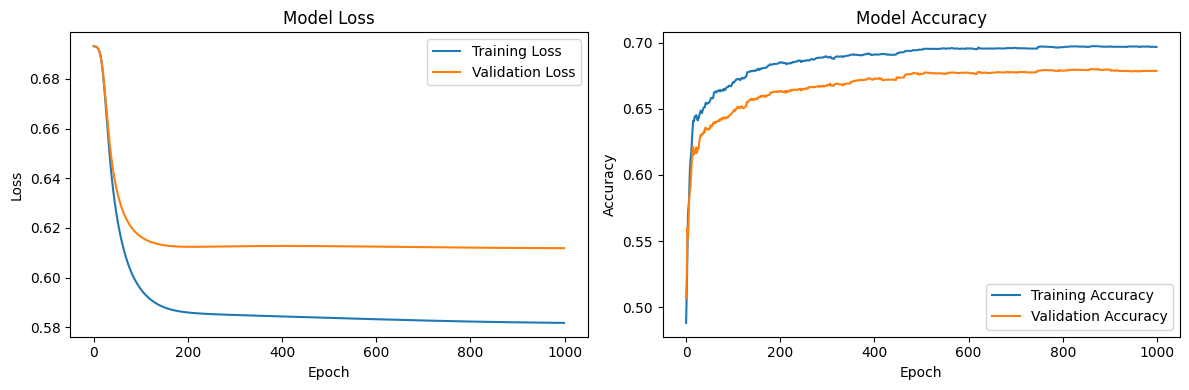


Model training completed!


In [9]:
# Train the model
import time

# Training parameters
epochs = 1000
batch_size = 5000
validation_split = 0.2

print("Starting model training...")
print(f"Epochs: {epochs}")
print(f"Batch size: {batch_size}")
print(f"Validation split: {validation_split}")

# Track training time
start_time = time.time()

# Train the model
history = model.fit(
    [center_data, context_data], 
    labels,
    validation_split=validation_split,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save model weights (optional)
# model.save_weights('./Networks/word2vec_negsample.weights.h5')
print("\nModel training completed!")


## Embedding Extraction and Visualization

Extract the learned word embeddings and visualize them in 2D space, highlighting hazard-related words.


In [10]:
# Function to extract embedding weights
def get_embedding_weights(model, layer_name):
    """
    Extract embedding weights from a specific layer
    """
    layer = model.get_layer(layer_name)
    weights = layer.get_weights()[0]
    return pd.DataFrame(weights, columns=[f'dim{i+1}' for i in range(weights.shape[1])])

# Extract center word embeddings
center_embeddings = get_embedding_weights(model, 'centerEmb')
print(f"Center embeddings shape: {center_embeddings.shape}")

# Extract context word embeddings  
context_embeddings = get_embedding_weights(model, 'contextEmb')
print(f"Context embeddings shape: {context_embeddings.shape}")

# Get hazard words for highlighting
hazard_words = []
if 'Hazard' in data_text.columns:
    unique_hazards = data_text['Hazard'].str.lower().unique()
    hazard_words = [word for word in unique_hazards if not pd.isna(word)]
    hazard_words.append('water')  # Add 'water'

print(f"Hazard words to highlight: {hazard_words}")

# Find indices of hazard words in vocabulary
hazard_indices = []
for word in hazard_words:
    for idx, vocab_word in tokenizer2.index_word.items():
        if vocab_word == word:
            hazard_indices.append(idx - 1)  # Convert to 0-based indexing
            break

print(f"Hazard word indices: {hazard_indices}")


Center embeddings shape: (127, 2)
Context embeddings shape: (127, 2)
Hazard words to highlight: ['lightning', 'vandalism', 'wind', 'vehicle', 'misc', 'waterw', 'waternw', 'fire', 'hail', 'water']
Hazard word indices: [1, 0, 7, 10, 5, 35, 2]


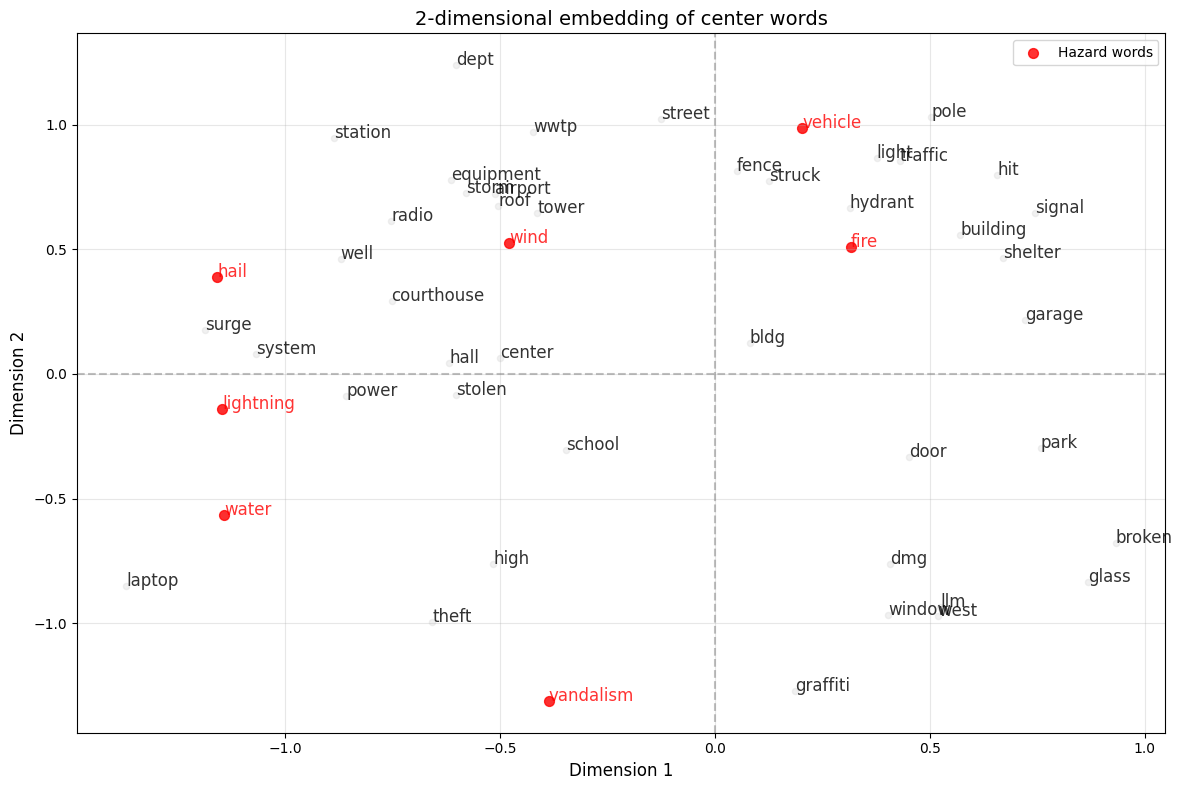

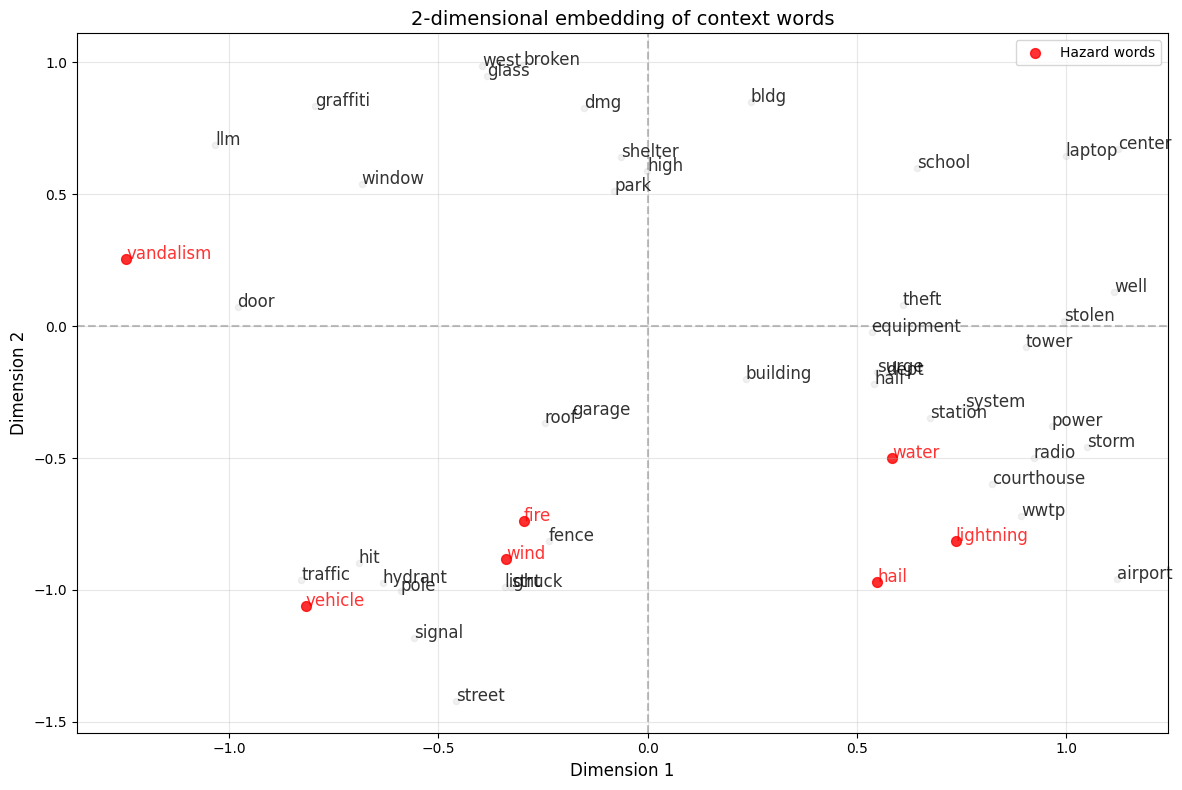

In [11]:
# Visualize center word embeddings
def plot_embeddings(embeddings, tokenizer, title, hazard_indices=None, max_words=50):
    """
    Plot 2D word embeddings
    """
    plt.figure(figsize=(12, 8))
    
    # Limit number of words to plot
    n_words = min(max_words, len(embeddings))
    
    # Plot all words
    x_coords = embeddings.iloc[:n_words]['dim1']
    y_coords = embeddings.iloc[:n_words]['dim2']
    
    plt.scatter(x_coords, y_coords, alpha=0.3, color='lightgray', s=20)
    
    # Add word labels
    for i in range(n_words):
        if i + 1 in tokenizer.index_word:  # +1 for 1-based indexing
            word = tokenizer.index_word[i + 1]
            color = 'red' if i in hazard_indices else 'black'
            plt.annotate(word, (x_coords.iloc[i], y_coords.iloc[i]), 
                        fontsize=12, color=color, alpha=0.8)
    
    # Highlight hazard words
    if hazard_indices:
        hazard_x = [x_coords.iloc[i] for i in hazard_indices if i < len(x_coords)]
        hazard_y = [y_coords.iloc[i] for i in hazard_indices if i < len(y_coords)]
        plt.scatter(hazard_x, hazard_y, color='red', s=50, alpha=0.8, label='Hazard words')
        plt.legend()
    
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    plt.xlabel('Dimension 1', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot center word embeddings
plot_embeddings(center_embeddings, tokenizer2, 
               '2-dimensional embedding of center words', 
               hazard_indices, max_words=50)

# Plot context word embeddings
plot_embeddings(context_embeddings, tokenizer2, 
               '2-dimensional embedding of context words', 
               hazard_indices, max_words=50)
